In [2]:
import os, json, shutil
from pycocotools.coco import COCO

# --- 1) 경로 설정 (윈도우 절대경로 사용) ---
data_dir = r"C:\coco"
ann_file = os.path.join(data_dir, "annotations", "instances_train2017.json")
img_src  = os.path.join(data_dir, "train2017")
out_dir  = r"C:\coco_subset"
os.makedirs(out_dir, exist_ok=True)

# --- 2) COCO API 로드 & 카테고리 ID 얻기 ---
coco    = COCO(ann_file)
targets = ['backpack', 'umbrella']
cat_ids = coco.getCatIds(catNms=targets)

# --- 3) subset 구조 준비 ---
subset = {
    'images':      [],
    'annotations': [],
    'categories':  coco.loadCats(cat_ids)
}

# --- 4) 이미지·어노테이션 필터링 ---
img_ids = coco.getImgIds(catIds=cat_ids)
for img_id in img_ids:
    img = coco.loadImgs(img_id)[0]
    subset['images'].append(img)

    ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=cat_ids, iscrowd=None)
    subset['annotations'].extend(coco.loadAnns(ann_ids))

# --- 5) JSON 저장 ---
with open(os.path.join(out_dir, 'instances_subset.json'), 'w', encoding='utf-8') as f:
    json.dump(subset, f, ensure_ascii=False)

# --- 6) 이미지 복사 ---
dst = os.path.join(out_dir, 'images')
os.makedirs(dst, exist_ok=True)
for img in subset['images']:
    shutil.copy(
        os.path.join(img_src, img['file_name']),
        os.path.join(dst,    img['file_name'])
    )

print(f"완료: {len(subset['images'])}장 저장됨.")


loading annotations into memory...
Done (t=10.58s)
creating index...
index created!
완료: 505장 저장됨.


In [4]:
import os, json, shutil
from pycocotools.coco import COCO

# --- 1) 경로 설정 (윈도우 절대경로 사용) ---
data_dir = r"C:\coco"
ann_file = os.path.join(data_dir, "annotations", "instances_train2017.json")
img_src  = os.path.join(data_dir, "train2017")
out_dir  = r"C:\coco_subset"
os.makedirs(out_dir, exist_ok=True)

# --- 2) COCO API 로드 & 카테고리 ID 얻기 ---
coco    = COCO(ann_file)
targets = ['backpack', 'umbrella']
cat_ids = coco.getCatIds(catNms=targets)

# --- 3) 전체 subset JSON 생성 (필요 시) ---
subset = {
    'images':      [],
    'annotations': [],
    'categories':  coco.loadCats(cat_ids)
}

# subset 내 이미지·어노테이션 필터링
for cat_id in cat_ids:
    img_ids = coco.getImgIds(catIds=[cat_id])
    # 각 이미지의 어노테이션만 추가
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        subset['images'].append(img_info)
        ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=[cat_id], iscrowd=None)
        subset['annotations'].extend(coco.loadAnns(ann_ids))

# 5) JSON 저장
with open(os.path.join(out_dir, 'instances_subset.json'), 'w', encoding='utf-8') as f:
    json.dump(subset, f, ensure_ascii=False, indent=2)

# --- 6) 클래스별로 이미지 복사 ---
for name, cid in zip(targets, cat_ids):
    class_dir = os.path.join(out_dir, name)
    os.makedirs(class_dir, exist_ok=True)
    img_ids = coco.getImgIds(catIds=[cid])
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        src_path = os.path.join(img_src, img_info['file_name'])
        dst_path = os.path.join(class_dir, img_info['file_name'])
        shutil.copy(src_path, dst_path)

print(f"완료: {targets[0]} {len(coco.getImgIds(catIds=[cat_ids[0]]))}장, {targets[1]} {len(coco.getImgIds(catIds=[cat_ids[1]]))}장 저장됨.")

loading annotations into memory...
Done (t=10.70s)
creating index...
index created!
완료: backpack 5528장, umbrella 3968장 저장됨.


In [2]:
import os, json, random, shutil

# ── 1) 환경 설정 ───────────────────────────────────────────────
BASE_DIR    = r"C:\coco_subset"               # coco_subset 최상위
JSON_PATH   = os.path.join(BASE_DIR, "instances_subset.json")
CLASS_DIRS  = {
    # JSON상의 category_id 순서와 무관하게 폴더 이름으로만 찾습니다
    "backpack": os.path.join(BASE_DIR, "backpack"),
    "umbrella": os.path.join(BASE_DIR, "umbrella"),
}
SPLIT_RATIO = 0.8    # train 80%, val 20%
OUTPUT_IMG  = os.path.join(BASE_DIR, "images")
OUTPUT_LBL  = os.path.join(BASE_DIR, "labels")

# ── 2) JSON 로드 및 매핑 생성 ───────────────────────────────────
with open(JSON_PATH, encoding="utf-8") as f:
    data = json.load(f)

# image_id → {file_name, width, height}
images = {img["id"]: img for img in data["images"]}

# image_id → [ann, ann, ...]
anns_by_image = {}
for ann in data["annotations"]:
    anns_by_image.setdefault(ann["image_id"], []).append(ann)

# category_id → 클래스 인덱스 (YOLO)
cat2idx = {cat["id"]: i for i, cat in enumerate(data["categories"])}
# 클래스 순서대로 names 리스트
names = [cat["name"] for cat in sorted(data["categories"], key=lambda x: cat2idx[x["id"]])]

# ── 3) Train/Val 이미지 분할 ───────────────────────────────────
all_ids = list(images.keys())
random.shuffle(all_ids)
n_train = int(len(all_ids) * SPLIT_RATIO)
train_ids, val_ids = set(all_ids[:n_train]), set(all_ids[n_train:])

# ── 4) 폴더 구조 만들기 ───────────────────────────────────────
for split in ("train", "val"):
    os.makedirs(os.path.join(OUTPUT_IMG, split), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_LBL, split), exist_ok=True)

# ── 5) 이미지 복사 & YOLO 라벨 생성 ─────────────────────────────
for img_id, img in images.items():
    fn     = img["file_name"]
    width  = img["width"]
    height = img["height"]

    # 원본 이미지 파일 경로 찾기 (backpack/umbrella 중 하나)
    src_path = None
    for dirname in CLASS_DIRS.values():
        p = os.path.join(dirname, fn)
        if os.path.exists(p):
            src_path = p
            break
    if src_path is None:
        continue  # 폴더에 없으면 무시

    # train 혹은 val 결정
    split = "train" if img_id in train_ids else "val"

    # 1) 이미지 복사
    dst_img = os.path.join(OUTPUT_IMG, split, fn)
    shutil.copy(src_path, dst_img)

    # 2) 라벨(txt) 생성
    lines = []
    for ann in anns_by_image.get(img_id, []):
        cid      = ann["category_id"]
        x, y, w, h = ann["bbox"]
        xc = (x + w/2) / width
        yc = (y + h/2) / height
        wn = w / width
        hn = h / height
        lines.append(f"{cat2idx[cid]} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")

    if not lines:
        continue
    lbl_path = os.path.join(OUTPUT_LBL, split, fn.replace(".jpg", ".txt"))
    with open(lbl_path, "w") as f:
        f.write("\n".join(lines))

print(f"✔️ 이미지 & 라벨 분할 완료: train={len(train_ids)}장, val={len(val_ids)}장")

# ── 6) data.yaml 생성 ─────────────────────────────────────────
yaml_path = os.path.join(BASE_DIR, "data.yaml")
train_path = OUTPUT_IMG.replace("\\", "/") + "/train"
val_path   = OUTPUT_IMG.replace("\\", "/") + "/val"

with open(yaml_path, "w") as f:
    f.write(f"nc: {len(names)}\n")
    f.write(f"names: {names}\n")
    f.write(f"train: {train_path}\n")
    f.write(f"val:   {val_path}\n")

print(f"✔️ data.yaml 생성: {yaml_path}")


✔️ 이미지 & 라벨 분할 완료: train=7192장, val=1799장
✔️ data.yaml 생성: C:\coco_subset\data.yaml


In [ ]:
# 0) 준비 ────────────────────────────────────────────────────────────────
import os, shutil, cv2
from pathlib import Path
from pycocotools.coco import COCO       # pip install pycocotools

ANN_PATH  = r"C:\coco\annotations\instances_train2017.json"
IMG_DIR   = r"C:\coco\train2017"
SAVE_DIR  = r"C:\coco\umbrella_closed"   # 결과 복사 위치
AR_THRESH = 2.5          # h/w ≥ 3  → 세로로 긴 물체만
MIN_AREA  = 32*32        # 너무 작은 박스 제외(옵션)

# 1) COCO 메타 로드 ─────────────────────────────────────────────────────
coco = COCO(ANN_PATH)                      # :contentReference[oaicite:0]{index=0}
umbrella_cat_id  = coco.getCatIds(catNms=['umbrella'])[0]  # 동적 조회
umbrella_img_ids = coco.getImgIds(catIds=[umbrella_cat_id])

# 2) 종횡비 필터링 ──────────────────────────────────────────────────────
candidates = []     # (img_id, ann_id, bbox) 저장
for img_id in umbrella_img_ids:
    for ann in coco.loadAnns(coco.getAnnIds(imgIds=[img_id],
                                            catIds=[umbrella_cat_id],
                                            iscrowd=False)):
        x, y, w, h = ann['bbox']          # COCO bbox = [x, y, w, h]
        if h/w >= AR_THRESH and w*h >= MIN_AREA:
            candidates.append((img_id, ann['id'], (x, y, w, h)))
            break                         # 한 장에 하나만 찾으면 충분

print(f"후보 이미지 수 : {len(candidates)}")

# 3) 확인용 썸네일 / 시각화 (선택) ───────────────────────────────────────
def draw_bbox(img_path, bbox, color=(0,255,0)):
    img = cv2.imread(img_path)
    x, y, w, h = map(int, bbox)
    cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
    return cv2.resize(img, (0,0), fx=0.5, fy=0.5)

sample_img_id, _, sample_bbox = candidates[0]
sample_info = coco.loadImgs(int(sample_img_id))[0]
cv2.imshow("folded umbrella?", draw_bbox(
    os.path.join(IMG_DIR, sample_info['file_name']), sample_bbox))
cv2.waitKey(0)

# 4) 접힌 우산 이미지 · 라벨 모아서 별도 폴더에 복사 ──────────────────
Path(SAVE_DIR, 'images').mkdir(parents=True, exist_ok=True)
Path(SAVE_DIR, 'labels').mkdir(exist_ok=True)

for img_id, ann_id, bbox in candidates:
    img_info = coco.loadImgs(int(img_id))[0]
    src_img  = os.path.join(IMG_DIR, img_info['file_name'])
    dst_img  = os.path.join(SAVE_DIR, 'images', img_info['file_name'])
    shutil.copy(src_img, dst_img)

    # YOLO txt 한 줄로 변환
    x, y, w, h = bbox
    x_c, y_c = x + w/2, y + h/2
    yolo_line = f"0 {x_c/img_info['width']:.6f} {y_c/img_info['height']:.6f} " \
                f"{w/img_info['width']:.6f} {h/img_info['height']:.6f}\n"
    with open(os.path.join(SAVE_DIR, 'labels',
             Path(img_info['file_name']).with_suffix('.txt').name), 'w') as f:
        f.write(yolo_line)

print("✓ 접힌 우산 후보 복사 완료!")


loading annotations into memory...
Done (t=10.04s)
creating index...
index created!
후보 이미지 수 : 240
✓ 접힌 우산 후보 복사 완료!


: 

In [ ]:
import cv2
import glob
import math
import os
from pathlib import Path
import matplotlib.pyplot as plt

IMG_DIR   = r"C:\coco\umbrella_closed\images"
LBL_DIR   = r"C:\coco\umbrella_closed\labels"
GRID_COLS = 5
MAX_IMGS  = None            # None → 전체

# ────────────────────────────────────────────
def read_yolo_label(lbl_path, img_w, img_h):
    """YOLO txt 한 줄 → [x1,y1,x2,y2] 좌표 반환 (0~1→픽셀)"""
    with open(lbl_path, "r") as f:
        for line in f:           # 한 이미지에 bbox 여러 개라도 반복
            _cls, xc, yc, w, h = map(float, line.split())
            x1 = int((xc - w/2) * img_w)
            y1 = int((yc - h/2) * img_h)
            x2 = int((xc + w/2) * img_w)
            y2 = int((yc + h/2) * img_h)
            yield (x1, y1, x2, y2)

def draw_bboxes(img_path, lbl_path, color=(0,255,0), thickness=2):
    img = cv2.imread(img_path)
    if img is None:                                       # 손상 파일 예외
        return None
    for x1,y1,x2,y2 in read_yolo_label(
            lbl_path,
            img.shape[1], img.shape[0]):
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)           # → Matplotlib용

# ────────────────────────────────────────────
img_paths = sorted(glob.glob(os.path.join(IMG_DIR, "*.jpg")))
if MAX_IMGS:
    img_paths = img_paths[:MAX_IMGS]

rows = math.ceil(len(img_paths) / GRID_COLS)
plt.figure(figsize=(GRID_COLS*4, rows*4))

for idx, img_path in enumerate(img_paths, 1):
    lbl_path = os.path.join(
        LBL_DIR,
        Path(img_path).with_suffix(".txt").name)
    vis = draw_bboxes(img_path, lbl_path)
    if vis is None:
        continue

    plt.subplot(rows, GRID_COLS, idx)
    plt.imshow(vis)
    plt.axis("off")
    plt.title(Path(img_path).name, fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# -*- coding: utf-8 -*-
"""
COCO 우산 → umbrella_closed(0) / umbrella_opened(1) YOLO 라벨 분리 스크립트
"""
import os, shutil, cv2
from pathlib import Path
from collections import defaultdict
from pycocotools.coco import COCO   # pip install pycocotools

# ───────────────────────────── 설정 ─────────────────────────────
ANN_PATH  = r"C:\coco\annotations\instances_train2017.json"
IMG_DIR   = r"C:\coco\train2017"
OUT_DIR   = r"C:\coco\umbrella_split"      # images / labels 하위 폴더 생성
AR_TH     = 2.5                            # h / w >= 2.5 ⇒ 접힌 우산
MIN_AREA  = 32*32                          # 작은 박스 제거(선택)

# ───────────────────────── COCO 메타 로드 ────────────────────────
coco           = COCO(ANN_PATH)
umbrella_cat   = coco.getCatIds(catNms=['umbrella'])[0]
umbrella_annId = coco.getAnnIds(catIds=[umbrella_cat], iscrowd=False)

# 이미지별 → [YOLO 라벨 문자열 …] 누적
labels_dict = defaultdict(list)

for ann in coco.loadAnns(umbrella_annId):
    img_info = coco.loadImgs(ann['image_id'])[0]
    x, y, w, h = ann['bbox']
    if w * h < MIN_AREA:
        continue                         # 너무 작은 박스 skip

    cls = 0 if h / w >= AR_TH else 1     # 0: closed, 1: opened

    # YOLO 상대좌표 (0~1)
    xc, yc = x + w / 2, y + h / 2
    yolo = f"{cls} {xc/img_info['width']:.6f} {yc/img_info['height']:.6f} " \
           f"{w/img_info['width']:.6f} {h/img_info['height']:.6f}\n"

    labels_dict[img_info['file_name']].append(yolo)

# ─────────────────────── 이미지·라벨 저장 ────────────────────────
img_out = Path(OUT_DIR, "images");  img_out.mkdir(parents=True, exist_ok=True)
lbl_out = Path(OUT_DIR, "labels");  lbl_out.mkdir(parents=True, exist_ok=True)

for file_name, yolo_lines in labels_dict.items():
    # 1) 이미지 복사 (이미 복사돼 있으면 skip)
    src = Path(IMG_DIR, file_name)
    dst = img_out / file_name
    if not dst.exists():
        shutil.copy(src, dst)

    # 2) 라벨 쓰기
    (lbl_out / Path(file_name).with_suffix(".txt").name).write_text("".join(yolo_lines))


loading annotations into memory...
Done (t=9.76s)
creating index...
index created!
✓ 변환 완료: 이미지 3,610장, closed 0개 / opened 0개


In [5]:
import glob, os

LBL_DIR = r"C:\coco\umbrella_split\labels"
closed_cnt = opened_cnt = 0

for txt in glob.glob(os.path.join(LBL_DIR, "*.txt")):
    with open(txt) as f:
        for line in f:
            if   line.startswith("0 "):  closed_cnt += 1
            elif line.startswith("1 "):  opened_cnt += 1

print(f"closed {closed_cnt:,}개 / opened {opened_cnt:,}개")

closed 10,014개 / opened 7,577개


In [4]:
# augment_closed.py
import os, glob, cv2, numpy as np
from pathlib import Path
from tqdm import tqdm
import albumentations as A

# ────────────── 설정 ───────────────────────────────────────────
ROOT          = r"C:\coco\umbrella_split"   # images/, labels/ 가 있는 곳
TARGET_FACTOR = 10                          # 10배 = 원본 + 9
IMG_DIR       = os.path.join(ROOT, "images")
LBL_DIR       = os.path.join(ROOT, "labels")

# ────────────── 1. closed 샘플 찾기 ────────────────────────────
closed_imgs = []
for lbl_path in glob.glob(os.path.join(LBL_DIR, "*.txt")):
    with open(lbl_path) as f:
        if any(line.startswith("0 ") for line in f):      # class 0 = closed
            closed_imgs.append(Path(lbl_path).with_suffix(".jpg").name)

print(f"closed 원본 : {len(closed_imgs)}장")

# ────────────── 2. 증강 파이프라인 정의 ────────────────────────
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RandomRotate90(p=0.5),
        A.Affine(
            scale=(0.8, 1.2),
            translate_percent=(0.0, 0.1),
            rotate=(-20, 20),
            fit_output=False,
            border_mode=cv2.BORDER_REFLECT_101,
            p=0.7,
        ),
        A.RandomBrightnessContrast(0.2, 0.2, p=0.5),
        A.RGBShift(15, 15, 15, p=0.3),
        A.MotionBlur(blur_limit=5, p=0.2),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        label_fields=["class_labels"],
        min_visibility=0.01,
        check_each_transform=False,
    ),
)

# ────────────── 3. bbox 보정 함수 ───────────────────────────────
def sanitize(bboxes):
    """
    (xc, yc, w, h) 4-tuple list → 0≤x_min,y_min,x_max,y_max≤1 보장
    w, h가 너무 크거나 음수일 때는 버린다.
    """
    fixed = []
    for xc, yc, w, h in bboxes:
        # 폭‧높이를 먼저 클램프
        w = np.clip(w, 1e-6, 1.0)
        h = np.clip(h, 1e-6, 1.0)

        # xc, yc가 w/2, h/2 를 벗어나지 않도록 교정
        xc = np.clip(xc, w / 2, 1.0 - w / 2)
        yc = np.clip(yc, h / 2, 1.0 - h / 2)

        fixed.append([float(xc), float(yc), float(w), float(h)])
    return fixed


# ────────────── 4. 증식 루프 ───────────────────────────────────
for img_name in tqdm(closed_imgs, desc="Augment"):
    img_path = os.path.join(IMG_DIR, img_name)
    lbl_path = os.path.join(LBL_DIR, Path(img_name).with_suffix(".txt").name)

    # 이미지·라벨 읽기 ----------------------------------------------------
    image = cv2.imread(img_path)
    if image is None:
        continue
    with open(lbl_path) as f:
        base_bboxes = []
        for ln in f:
            cls, *xywh = ln.split()
            if cls == "0":                     # closed 박스만
                base_bboxes.append(list(map(float, xywh)))
    base_bboxes = sanitize(base_bboxes)
    if not base_bboxes:
        continue
    class_labels = ["0"] * len(base_bboxes)

    # ------------------------------------------------------------ 증식
    for idx in range(TARGET_FACTOR - 1):      # 원본 제외 n-1번
        aug = transform(
            image=image, bboxes=base_bboxes, class_labels=class_labels
        )
        fixed = sanitize(aug["bboxes"])
        if not fixed:
            continue                          # 박스 모두 날아가면 skip

        new_stem = f"{Path(img_name).stem}_caug{idx}"
        new_img  = os.path.join(IMG_DIR, f"{new_stem}.jpg")
        new_lbl  = os.path.join(LBL_DIR, f"{new_stem}.txt")

        cv2.imwrite(new_img, aug["image"])
        with open(new_lbl, "w") as f:
            for bb in fixed:
                f.write("0 " + " ".join(f"{v:.6f}" for v in bb) + "\n")

print("✓ 증식 완료")


closed 원본 : 391장


Augment: 100%|██████████| 391/391 [00:17<00:00, 22.24it/s]

✓ 증식 완료


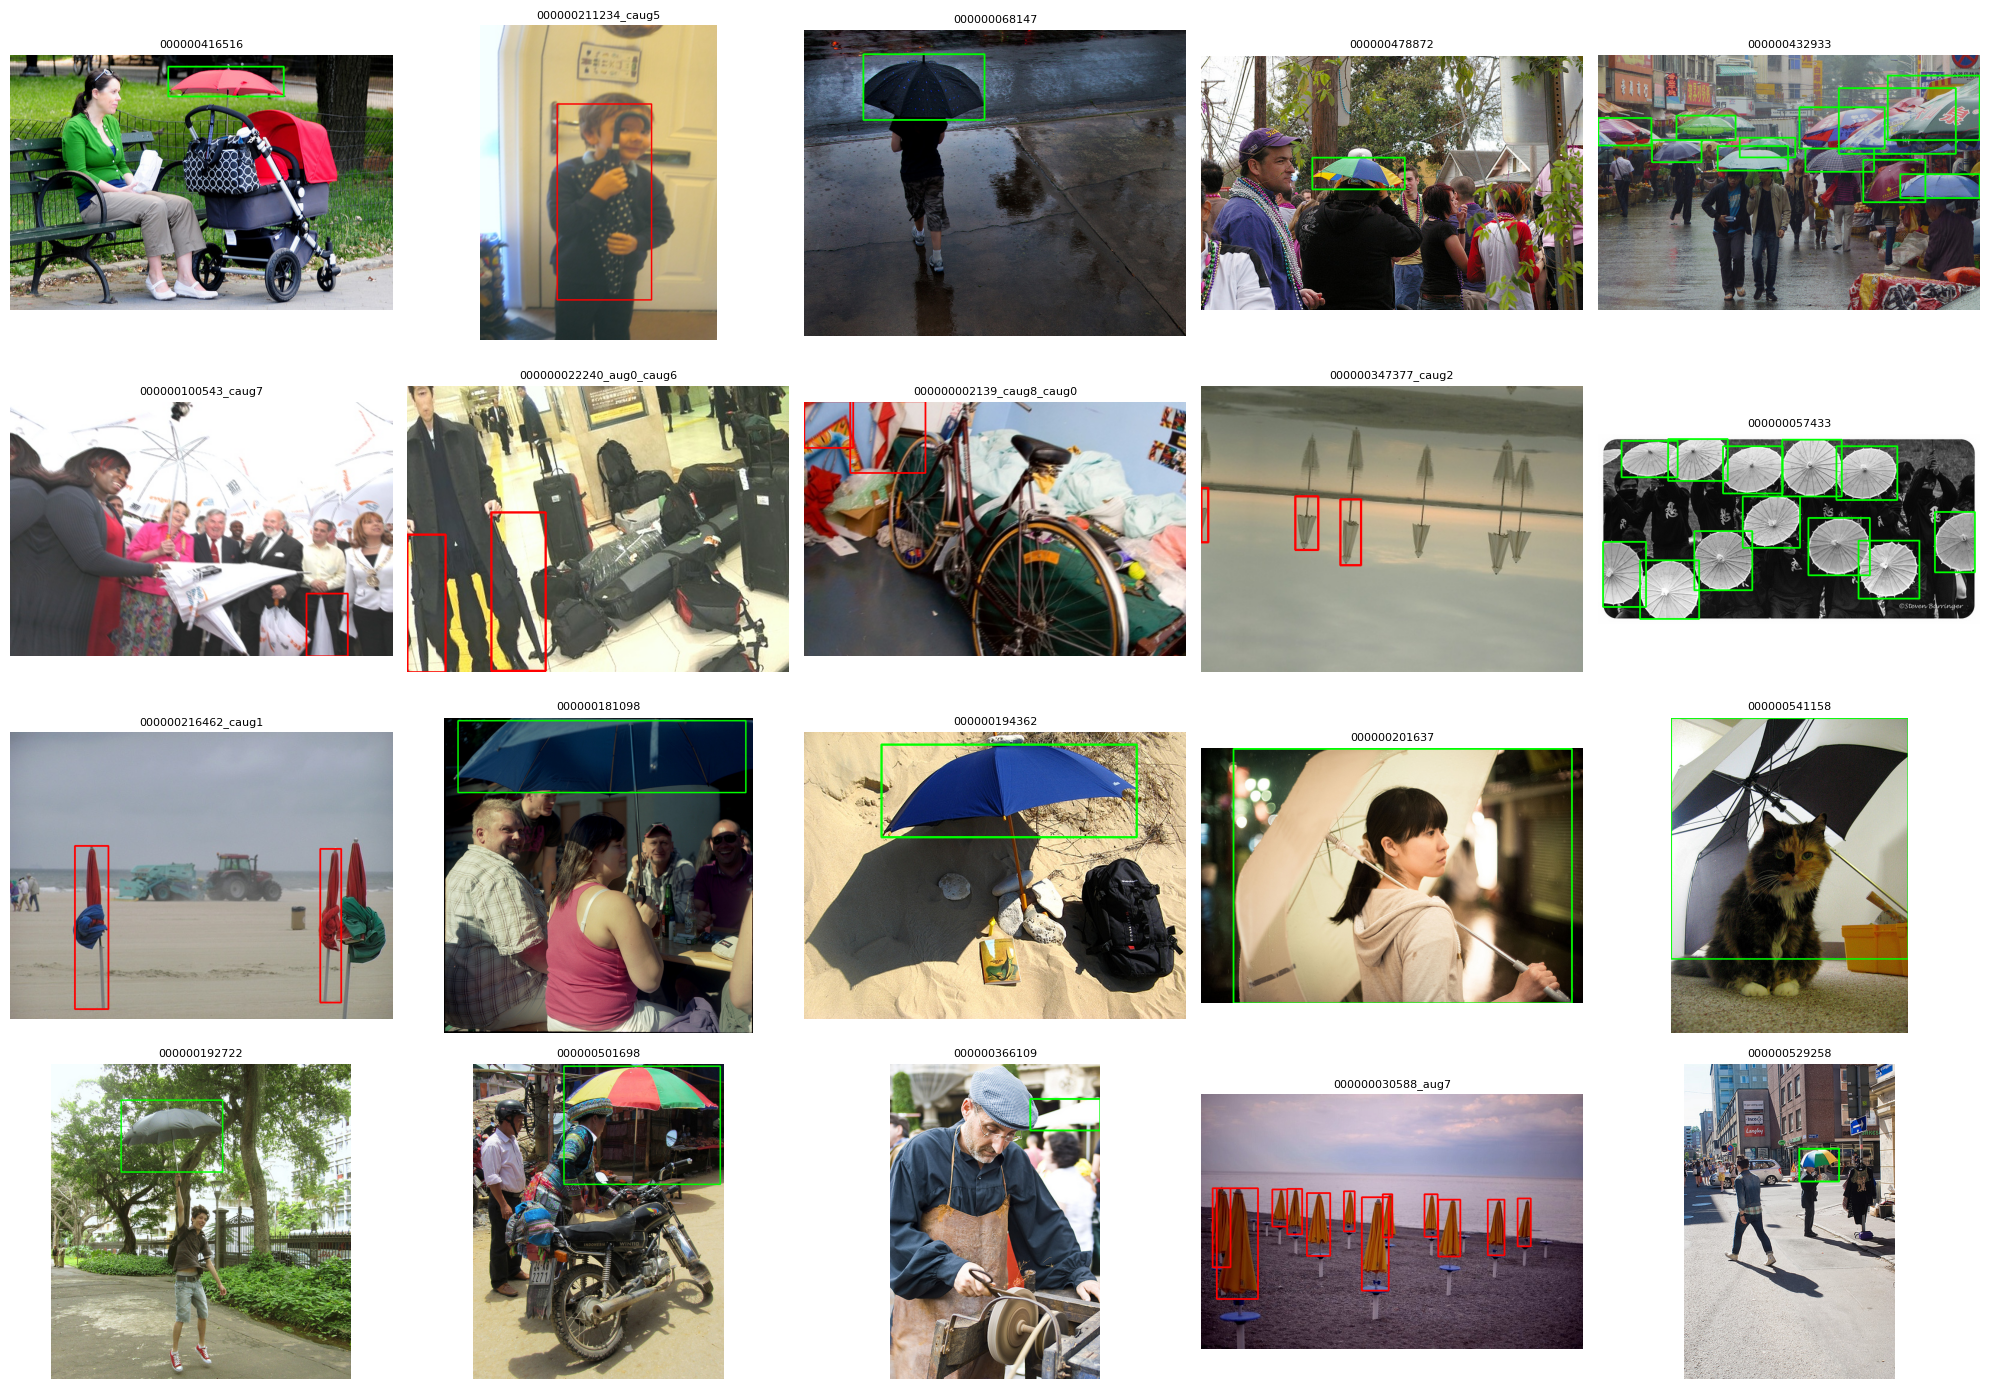

In [6]:
# visualize_augmented.py
import os, glob, random, cv2, math
from pathlib import Path
import matplotlib.pyplot as plt

ROOT   = r"C:\coco\umbrella_split"        # images / labels
IMGDIR = os.path.join(ROOT, "images")
LBLDIR = os.path.join(ROOT, "labels")
N_SAMPLES = 20                            # 보고 싶은 이미지 수
COLS      = 5                             # 그리드 열 수

# ───────── 1) 무작위 샘플 N개 선택 ─────────────────────────────────────
candidates = random.sample(
    glob.glob(os.path.join(IMGDIR, "*.*g")),   # jpg, png …
    k=min(N_SAMPLES, len(os.listdir(IMGDIR)))
)

# ───────── 2) 보조 함수: 라벨 → 박스 그리기 ───────────────────────────
def draw_yolo_bbox(img_path, lbl_path):
    img  = cv2.imread(img_path)
    if img is None:
        return None
    h, w = img.shape[:2]

    # txt 읽기
    if os.path.exists(lbl_path):
        for line in open(lbl_path):
            cls, xc, yc, bw, bh = map(float, line.split())
            # ✔️ class 색상 구분 (0=빨강=closed, 1=초록=opened)
            color = (0, 0, 255) if cls == 0 else (0, 255, 0)
            # YOLO → 픽셀 사각형
            x1 = int((xc - bw / 2) * w)
            y1 = int((yc - bh / 2) * h)
            x2 = int((xc + bw / 2) * w)
            y2 = int((yc + bh / 2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ───────── 3) Matplotlib 그리드로 시각화 ───────────────────────────────
rows = math.ceil(len(candidates) / COLS)
plt.figure(figsize=(COLS * 4, rows * 3.5))

for i, img_path in enumerate(candidates, 1):
    stem = Path(img_path).stem
    lbl_path = os.path.join(LBLDIR, f"{stem}.txt")
    vis = draw_yolo_bbox(img_path, lbl_path)
    if vis is None:
        continue
    plt.subplot(rows, COLS, i)
    plt.imshow(vis)
    plt.axis("off")
    plt.title(stem, fontsize=8)

plt.tight_layout()
plt.show()
